In [1]:
import numpy as np
from scipy.linalg import block_diag
import scipy
import matplotlib.pyplot as plt
from proSVD import proSVD
from functools import reduce

rng = np.random.default_rng()

In [2]:
from scipy.stats import special_ortho_group



def random_mat_leq_theta(theta, d=3):
    rmm = special_ortho_group(dim=d, seed=rng)
    Q = rmm.rvs()
    while np.linalg.det(Q) > 0 and np.arccos((np.trace(Q) - 1)/2) > theta:
        Q = rmm.rvs()
    return Q

In [3]:
def trivial_make_G(B, k):
    u, s, vt = np.linalg.svd(B)
    G_u = u[:,:k]
    G_v = (vt.T)[:,:k]
    return G_u, G_v

In [4]:
def prosvd_make_G(B,k):
    alpha = 1
    
    u, sigma, vt = np.linalg.svd(B)

    u_tilde, sigma_tilde, vt_tilde = np.linalg.svd(u[:k, :k])
    
    T = (u_tilde @ vt_tilde).T

    G_u = u[:,:k] @ T
    G_v = vt.T
    
    return G_u, G_v

In [5]:
def general_incremental_svd(A_sequence, make_G_matrices=trivial_make_G, max_k=10):
    A =  A_sequence[0]
    l = A.shape[1]
    Q, B = np.linalg.qr(A)
    W = np.eye(l)
    k = l
    
    for A in A_sequence[1:]:
        l = A.shape[1]

        B_in = Q.T @ A
        A_orth = A - Q @ B_in
        Q_orth, B_orth = np.linalg.qr(A_orth)
        
        Q = np.hstack([Q, Q_orth]) # Q hat
        zero_block = np.zeros((B_orth.shape[0],B.shape[1]))
        B =  np.block([
            [B,          B_in],
            [zero_block, B_orth]
        ])
        W = block_diag(W, np.eye(l))
        
        G_u, G_v = make_G_matrices(B, max_k)

        k = min(k + l, max_k)
        G_u, G_v = G_u[:,:k], G_v[:,:k]
        
        B = G_u.T @ B @ G_v
        Q = Q @ G_u
        W = W @ G_v
        
    return Q, B, W

In [17]:
A_sequence = [rng.normal(size=(2,1)) + np.array([3,3]) for _ in range(10)]
Q, B, W = general_incremental_svd(A_sequence, max_k=1)

In [18]:
Q @ B @ W.T

array([[3.48237723, 3.48237723, 3.87583244, 3.87583244, 2.51621487,
        2.51621487, 3.4321911 , 3.4321911 , 4.65803645, 4.65803645,
        2.92345207, 2.92345207, 3.54126275, 3.54126275, 3.13194869,
        3.13194869, 3.21238509, 3.21238509, 3.53189446, 3.53189446],
       [3.21300904, 3.21300904, 3.57602977, 3.57602977, 2.32158109,
        2.32158109, 3.1667049 , 3.1667049 , 4.29772888, 4.29772888,
        2.69731775, 2.69731775, 3.26733965, 3.26733965, 2.88968677,
        2.88968677, 2.96390127, 2.96390127, 3.25869602, 3.25869602]])

In [8]:
A_sequence

[array([0.79977316, 1.39442531]),
 array([0.54403783, 2.12358085]),
 array([0.28030696, 1.95841922]),
 array([ 1.92528945, -0.44365233]),
 array([0.31269822, 3.13087063]),
 array([0.41547366, 0.16696231]),
 array([3.24797969, 1.58804588]),
 array([-0.69344158,  3.00634528]),
 array([0.65236973, 1.00714953]),
 array([4.20425931, 1.00325642])]

In [6]:
A_sequence = [rng.normal(size=(2,1)) for _ in range(10)]
A_full = np.column_stack(A_sequence)

for f in [trivial_make_G, prosvd_make_G]:
    Q, B, W = general_incremental_svd(A_sequence, f)
    assert np.allclose(Q @ B @ W.T, A_full)

In [7]:
A_sequence = [rng.normal(size=(3,4)) for _ in range(10)]
A_full = np.column_stack(A_sequence)

d=4
Q, B, W = general_incremental_svd(A_sequence, prosvd_make_G, max_k=d)



p = proSVD(d)

p.initialize(A_sequence[0])
for A in A_sequence[1:]:
    p.preupdate()
    p.updateSVD(A)
    p.postupdate()

assert np.allclose(p.Q,  Q)

# Biased proSVD

In [8]:
def biased_pro_svd(A_sequence, make_G_matrices=trivial_make_G, max_k=10):
    A =  A_sequence[0]
    l = A.shape[1]
    Q, B = np.linalg.qr(A)
    W = np.eye(l)
    k = l
    QBWs = [(Q, B, W)]
    for A in A_sequence[1:]:
        l = A.shape[1]

        B_in = Q.T @ A
        A_orth = A - Q @ B_in
        Q_orth, B_orth = np.linalg.qr(A_orth)
        
        Q = np.hstack([Q, Q_orth]) # Q hat
        zero_block = np.zeros((B_orth.shape[0],B.shape[1]))
        B =  np.block([
            [B,          B_in],
            [zero_block, B_orth]
        ])
        W = block_diag(W, np.eye(l))
        
        u, sigma, vt = np.linalg.svd(B)
        u_tilde, sigma_tilde, vt_tilde = np.linalg.svd(u[:max_k, :max_k])
        T = (u_tilde @ vt_tilde).T
        G_u = u[:,:max_k] @ T
        G_v = vt.T

        k = min(k + l, max_k)
        G_u, G_v = G_u[:,:k], G_v[:,:k]
        
        B = G_u.T @ B @ G_v
        Q = Q @ G_u
        W = W @ G_v
        QBWs.append((Q, B, W))
    return QBWs

In [9]:
n_points = 50
d = 10
max_k = 3
A_sequence = []

for i in range(n_points):
    cov = [10, 10, 10]
    cov = np.diag(cov + [1 for _ in range(d - len(cov))])
    mean = [i/n_points * 100,0,0]
    mean = np.array(mean + [0 for _ in range(d - len(mean))])
    A = rng.multivariate_normal(mean=mean, cov=cov, size=max_k)
    A_sequence.append(A.T)

for i in range(n_points):
    cov = [10, 10, 10]
    cov = np.diag(cov + [1 for _ in range(d - len(cov))])
    mean = [np.cos(i / n_points) * 100, np.sin(i/n_points) * 100, 0]
    mean = np.array(mean + [0 for _ in range(d - len(mean))])
    A = rng.multivariate_normal(mean=mean, cov=cov, size=max_k)
    A_sequence.append(A.T)
    
A_full = np.column_stack(A_sequence)

QBWs = biased_pro_svd(A_sequence, max_k=max_k)
Qs, Bs, Ws = zip(*QBWs)

print(f"{np.allclose(Qs[-1] @ Bs[-1] @ Ws[-1].T, A_full)}")

False


In [10]:
n_points = 50
d = 10
max_k = 3
A_sequence = []

for i in range(n_points):
    cov = [10, 10, 10, 1]
    cov = np.diag(cov + [1 for _ in range(d - len(cov))])
    mean = []
    mean = np.array(mean + [0 for _ in range(d - len(mean))])
    A = rng.multivariate_normal(mean=mean, cov=cov, size=max_k)
    A_sequence.append(A.T)

for i in range(n_points):
    cov = [10, 10, 10, i]
    cov = np.diag(cov + [1 for _ in range(d - len(cov))])
    mean = []
    mean = np.array(mean + [0 for _ in range(d - len(mean))])
    A = rng.multivariate_normal(mean=mean, cov=cov, size=max_k)
    A_sequence.append(A.T)

A_full = np.column_stack(A_sequence)

QBWs = biased_pro_svd(A_sequence, max_k=max_k)
Qs, Bs, Ws = zip(*QBWs)

print(f"{np.allclose(Qs[-1] @ Bs[-1] @ Ws[-1].T, A_full)}")

False


Text(0, 0.5, 'norm stepwise change in the nth column of Q')

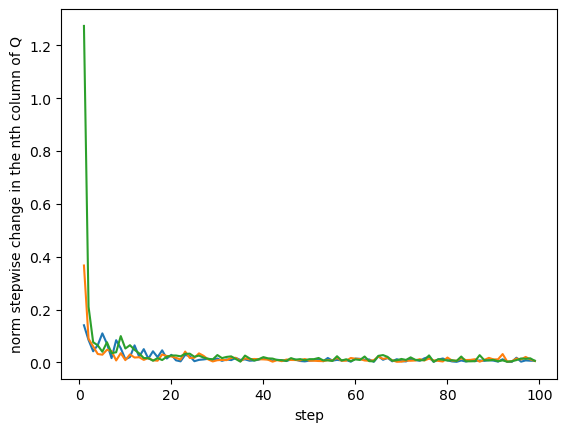

In [11]:
plt.plot(np.arange(len(Qs)-1)+1,np.linalg.norm(np.diff(np.array(Qs), axis=0), axis=1))
plt.xlabel("step")
plt.ylabel("norm stepwise change in the nth column of Q")

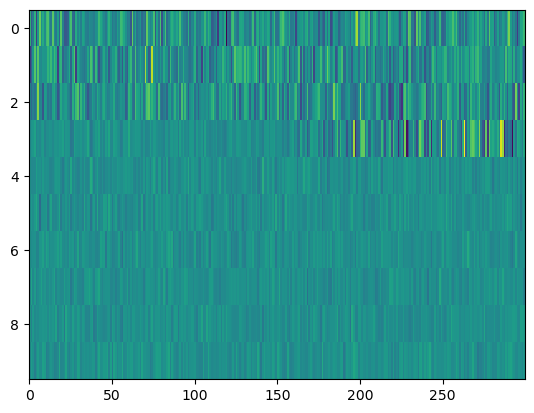

In [12]:
plt.imshow(A_full, aspect='auto', interpolation="nearest")

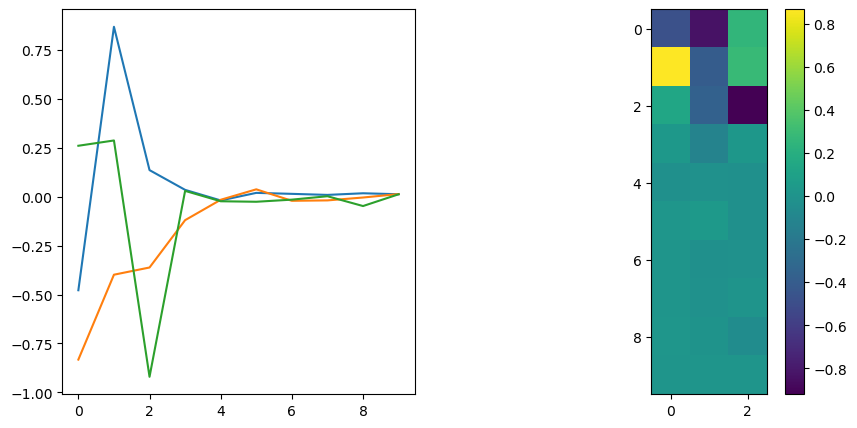

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(10,5))

im = ax[0,1].imshow(Qs[-1], interpolation='nearest')
fig.colorbar(im);
# plt.subplot(1,2,2)
ax[0,0].plot(Qs[-1])

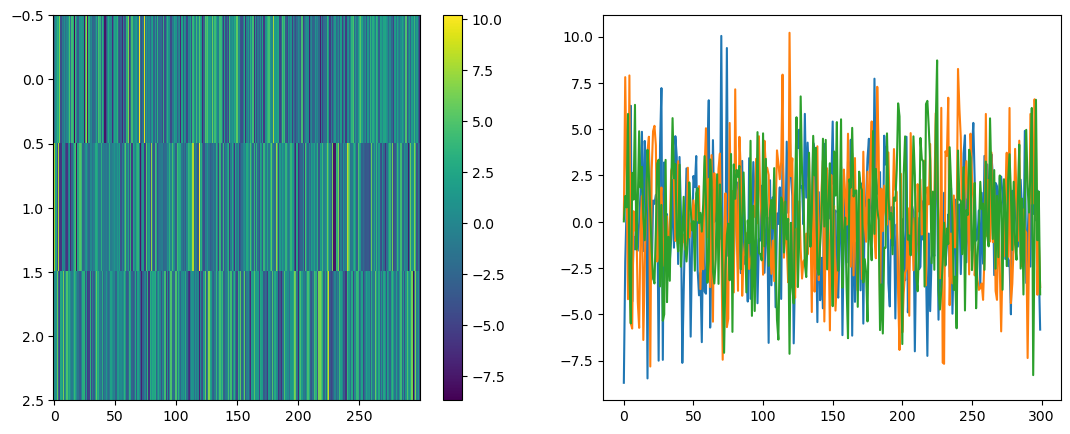

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(13,5))
H = Bs[-1] @ Ws[-1].T
im = ax[0,0].imshow(H, aspect='auto', interpolation='nearest')
fig.colorbar(im);
# plt.subplot(1,2,2)
ax[0,1].plot(H.T)

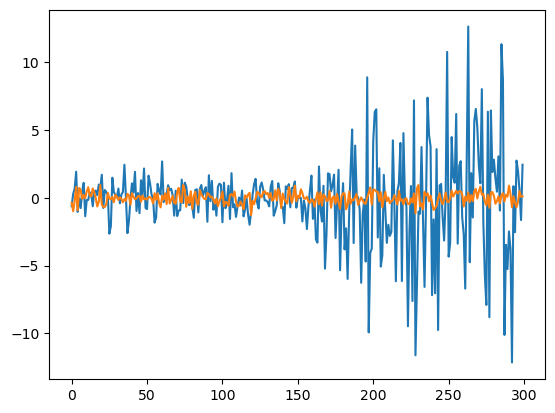

In [15]:
idx = 3
plt.plot(A_full[idx,:])
plt.plot((Qs[-1]@Qs[-1].T@A_full)[idx,:])

# real data

In [16]:
import timeit
import numpy as np
import adaptive_latents.input_sources as ins
from adaptive_latents import default_rwd_parameters, Bubblewrap, SymmetricNoisyRegressor
from proSVD import proSVD

identifier = ins.datasets.individual_identifiers["buzaki"][0]
bin_width = 0.03
obs, position_data, obs_t, position_data_t = ins.datasets.construct_buzaki_data(individual_identifier=identifier, bin_width=bin_width)

position_data = ins.functional.resample_behavior(raw_behavior=position_data, bin_centers=obs_t, t=position_data_t)
position_data = position_data[:,:2]


retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/buzaki_data_848111633121927.pickle


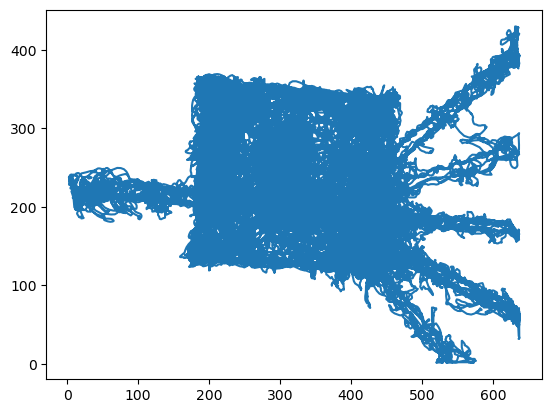

In [17]:
plt.plot(position_data[:,0], position_data[:,1])

In [18]:
max_k = 6
stride = 5
A_sequence = []

to_partition = scipy.stats.zscore(np.hstack([obs, position_data]))
to_partition = obs
for i in range(100):
    new = to_partition[stride*i:stride*i+stride].T
    A_sequence.append(new)
    
A_full = np.column_stack(A_sequence)
QBWs = biased_pro_svd(A_sequence, max_k=max_k)
Qs, Bs, Ws = zip(*QBWs)

58.56175604848012


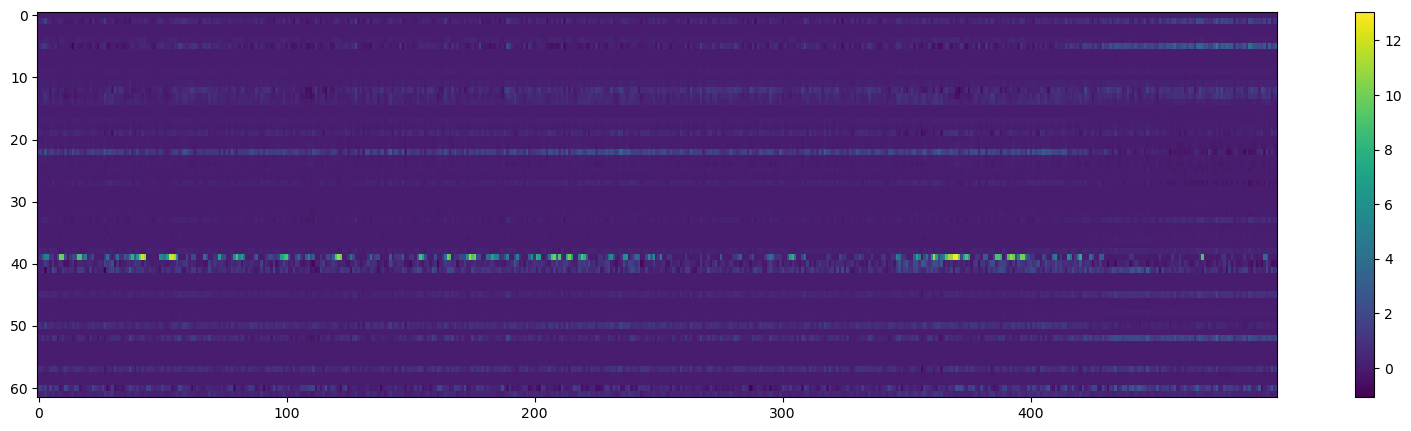

In [19]:
reconstruction = Qs[-1] @ Bs[-1] @ Ws[-1].T
fig, ax = plt.subplots(figsize=(20,5))
im = ax.imshow(reconstruction, aspect='auto', interpolation='nearest')
print(np.linalg.norm(reconstruction - A_full))
fig.colorbar(im);

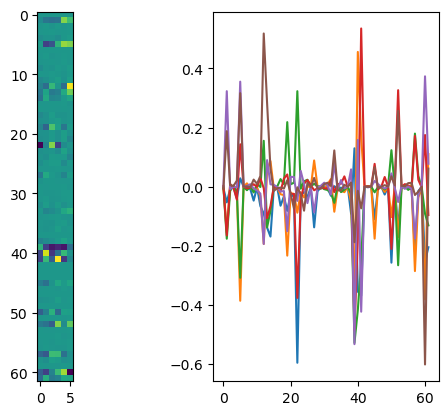

In [20]:
plt.subplot(1,2,1)
plt.imshow(Qs[-1])
plt.subplot(1,2,2)
plt.plot(Qs[-1]);

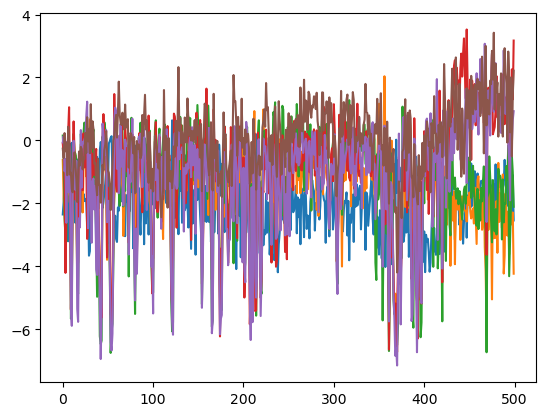

In [21]:
plt.plot((Bs[-1] @ Ws[-1].T).T);

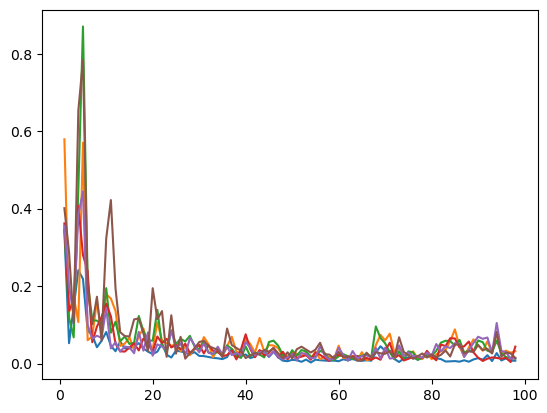

In [22]:
Qs_slice = Qs[1:]
plt.plot(np.arange(len(Qs_slice)-1)+1,np.linalg.norm(np.diff(np.array(Qs_slice), axis=0), axis=1));

In [23]:
from sklearn.decomposition import non_negative_factorization

In [24]:
W, H, _ = non_negative_factorization(A_full,n_components=max_k)

56.368662081465054


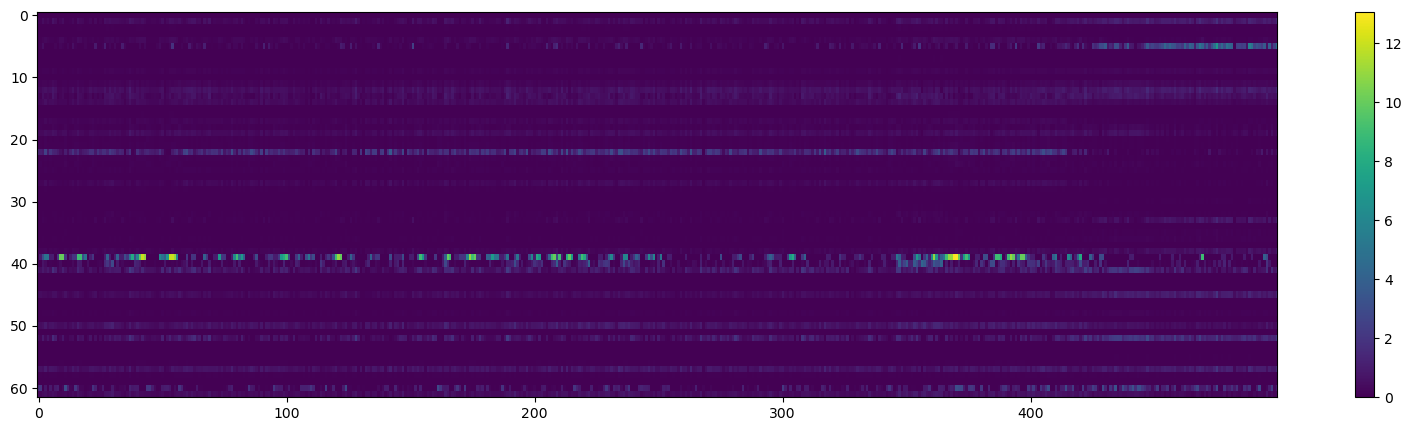

In [25]:
reconstruction = W @ H
fig, ax = plt.subplots(figsize=(20,5))
im = ax.imshow(reconstruction, aspect='auto', interpolation='nearest')
print(np.linalg.norm(reconstruction - A_full))
fig.colorbar(im);

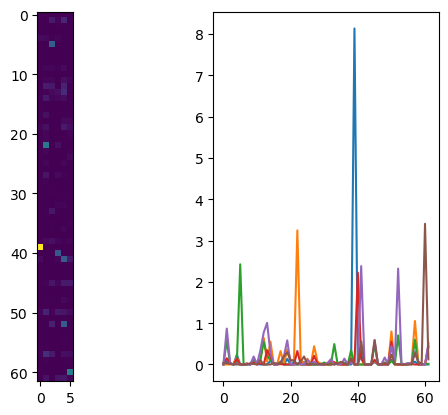

In [26]:
plt.subplot(1,2,1)
plt.imshow(W)
plt.subplot(1,2,2)
plt.plot(W);

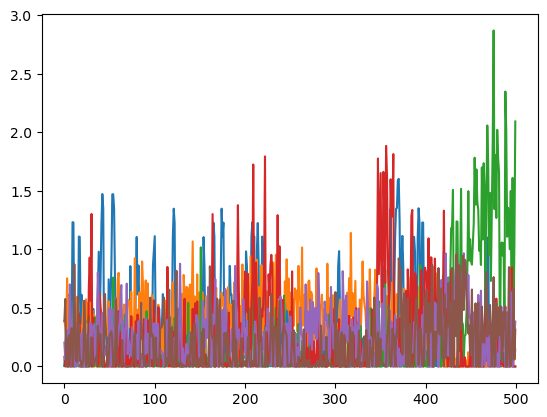

In [27]:
plt.plot(H.T)

### Procrustes

In [28]:
A = rng.random(size=(3,3))

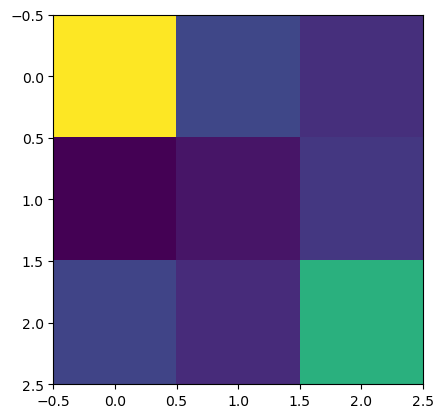

In [29]:
fig, ax = plt.subplots()
ax.imshow(A);

In [30]:
magnitudes = []
points = []

random_mat_maker = special_ortho_group(dim=A.shape[0], seed=rng).rvs


for _ in range(10_000):
    # random_mat = rng.random(size=(A.shape[0],A.shape[0]))
    # q_qr,_ = np.linalg.qr(random_mat)
    # q_svd,_,_ = np.linalg.svd(random_mat)
    # q = q_qr
    # q = q[rng.permutation(q.shape[0])]
    
    q = random_mat_maker()
    m = ((A - q)**2).sum()
    
    
    
    assert np.allclose(q.T@q, np.eye(A.shape[0])) and np.allclose(q@q.T, np.eye(A.shape[0]))
    points.append(q[:,0])
    magnitudes.append(m)

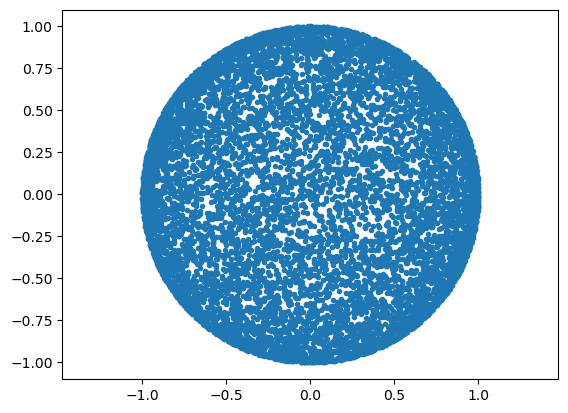

In [31]:
points = np.array(points)
plt.plot(points[:,0], points[:,1], '.')
plt.axis("equal");

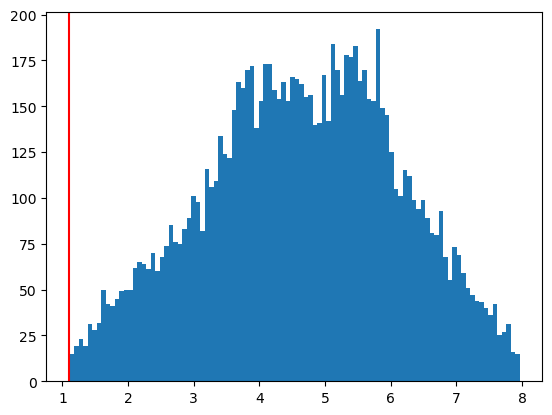

In [32]:
u, s, vh = np.linalg.svd(A)
q = u @ vh
m = ((A - q)**2).sum()
assert np.allclose(q.T@q, np.eye(A.shape[0])) and np.allclose(q@q.T, np.eye(A.shape[0]))

plt.axvline(m, color='red')
plt.hist(magnitudes, bins=100);